# Where should I place a hotel to give tourists access to most points of information?

In [152]:
%matplotlib inline
# notebook
import matplotlib.pylab as pylab
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.cluster import KMeans
from collections import Counter
import numpy as np
from sklearn.decomposition import PCA
import pandas as pd
import networkx as nx
from math import sin, cos, sqrt, atan2, radians,pi
#make the graphs bigger
pylab.rcParams['figure.figsize'] = (32.0, 24.0)
pylab.rcParams['font.size'] = 24

In [172]:
def listedEiggHotels():
    hotels = {}
    hotels['56.9214209,-6.1472527'] = "Tigh an Sithean – camping cabins & log cabins"
    hotels['56.9195159,-6.1484787'] = "Lageorna"
    hotels['56.9252864,-6.1471206'] = "Tophouse"
    hotels['56.888082, -6.137512'] = "Amazing Eigg Shed" #ref, Airbnb https://www.airbnb.co.uk/rooms/16893915?source_impression_id=p3_1582112234_GzrTX7%2FlFXGr%2FdFV
    hotels['56.922044,-6.1446842'] = "Eigg Organics"
    hotels['56.8889489,-6.1250917'] = "Kildonnan house"
    hotels['56.9182625,-6.1554283'] = "Laig Caravan"
    hotels['56.8902145,-6.1343823'] = "Glebe Barn"
    hotels['56.8775889,-6.1337773'] = "The Smiddy"
    hotels['56.9222615,-6.1420233'] = "Sweeney's Bothy"
    hotels['56.9131675,-6.1619473'] = "Laig Beach Bothy"
    hotels['56.8779645,-6.1327783'] = "Eigg Camping Pods"
    hotels['56.9223021,-6.1480099'] = "Tigh Eilidh"
    hotels['56.8804676,-6.1417635'] = "Eigg Eco Centre"
    hotels['56.8777055,-6.1316373'] = "Clanranald college"
    hotels['56.9269519,-6.1439637'] = "Howlin Cottege"
    hotels['56.9017079,-6.1425028'] = "Cuagath Bothy"
    
    return hotels

## Residences locations
def pointsOfInterest():
    interests = {}
    interests['56.8781465,-6.1326085'] = "historic memorial"
    interests['56.9003152,-6.1404042'] = "historic monument"
    interests['56.9199238,-6.1467235'] = "historic memorial"
    
    interests['56.8797535,-6.1267920'] = "ferry_terminal"
    interests['56.9190886,-6.1463398'] = "restaurant"        
    interests['56.8798083,-6.1462677'] = "Town Hall"
    interests['56.8932164,-6.1448756'] = "Church"
    interests['56.9025486,-6.1389638'] = "Primary School"
    interests['56.9031345,-6.1392428'] = "Heritage Trust"
    interests['56.917479,-6.1453462'] = "Roman Church"
    interests['56.8802725,-6.1417391'] = "Eco Center"
    interests['56.901693,-6.141992'] = "Old Museum"
    interests['56.9199238,-6.1467235'] = 'Eigg War Memorial'
    interests['56.8709333,-6.1213667'] = "lighthouse"
    
    #naturals
    
    interests['56.8840899,-6.1652639'] = "Peak"
    interests['56.8736995,-6.1455634'] = "Cave Entrance"
    interests['56.8735485,-6.1499874'] = "Cave Entrance"
    interests['56.9187381,-6.1651365'] = "Bay"
    interests['56.9264321,-6.1333792'] = "Peak"
    interests['56.8693995,-6.1271392'] = "Peak"
    interests['56.9034271,-6.1912247'] = "Peak"
    interests['56.9136453,-6.1311475'] = "Peak"
    interests['56.8911480,-6.1761228'] = "Peak"
    interests['56.8643159,-6.2062335'] = "Strait"
    interests['56.9399878,-6.2222024'] = "Strait"
    interests['56.8794302,-6.1776533'] = "Grulin"
    interests['56.8840899,-6.1652639'] = "An Sgurr"
    interests['56.8736995,-6.1455634'] = "Massacre Caves"
    interests['56.9187381,-6.1651365'] = "Laig Bay"
    interests['56.8781465,-6.1326085'] = "Sgurr Stone"
    interests['56.9264321,-6.1333792'] = "Sgorr an Fharaidh"
    interests['56.8693995,-6.1271392'] = "Maol an Eilean"
    interests['56.9034271,-6.1912247'] = "Beinn Tighe"
    interests['56.9136453,-6.1311475'] = "Beinn Tighe"
    interests['56.8911480,-6.1761228'] = "Cora Bheinn"
    
    return interests

def graphTwoSetsByObservations(buildingLocs,obsLocs,dist=500):
    distance_away = dist

    G = nx.Graph()

    colorMap = (['gold'] * len(buildingLocs)) + (['blue'] * len(obsLocs))

    for k,r in enumerate(buildingLocs):
        G.add_node(k, color="green")

    for k,o in enumerate(obsLocs):
        G.add_node(k+len(buildingLocs), color="blue")

    for o_index,o in enumerate(obsLocs):
        for r_index,r in enumerate(buildingLocs):
            if seperationInMetres(o,r) < distance_away:
                G.add_edge(o_index+len(buildingLocs),r_index)
                
    return G, colorMap

def getIsolatesAtOffset(G,offset):
    degrees = G.degree()
    degreesOfInterest = filter(lambda x: x[1] == 0,degrees)
    degreesOfInterest = filter(lambda x: x[0] > offset, degreesOfInterest)
    nodeIds = map(lambda x: x[0],degreesOfInterest)
    
    return list(nodeIds)

def getBoundingBox(latLons):
    lats = list(map(lambda x: x[0],latLons))
    lons = list(map(lambda x: x[1],latLons))
        
    return [[min(lats),max(lats)],[min(lons),max(lons)]]

def transformLatLonByXMetres(lat,lon,dn,de):
    R=6378137
    dLat = dn/R
    dLon = de/(R*cos(pi*lat/180))
    latO = lat + dLat * 180/pi
    lonO = lon + dLon * 180/pi

    return (latO,lonO)

def seperationInMetres(p1,p2):
    R = 6373.0
    
    lat1,lon1 = p1
    lat2, lon2 = p2
    
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c

    #convert to metres
    return distance * 1000 

def convertToUsableLatLon(dict_):    
    curr = list(map(lambda x: x.split(","),dict_.keys()))
    curr = list(map(lambda x: [float(x[0]),float(x[1])], curr))
    return curr

def addPseudoHotel(lat,lon):
    hotels = listedEiggHotels()
    hotels[",".join([str(lat),str(lon)])] = "Pseudo"
    
    return hotels

interests = convertToUsableLatLon(pointsOfInterest())
hotels = convertToUsableLatLon(listedEiggHotels())

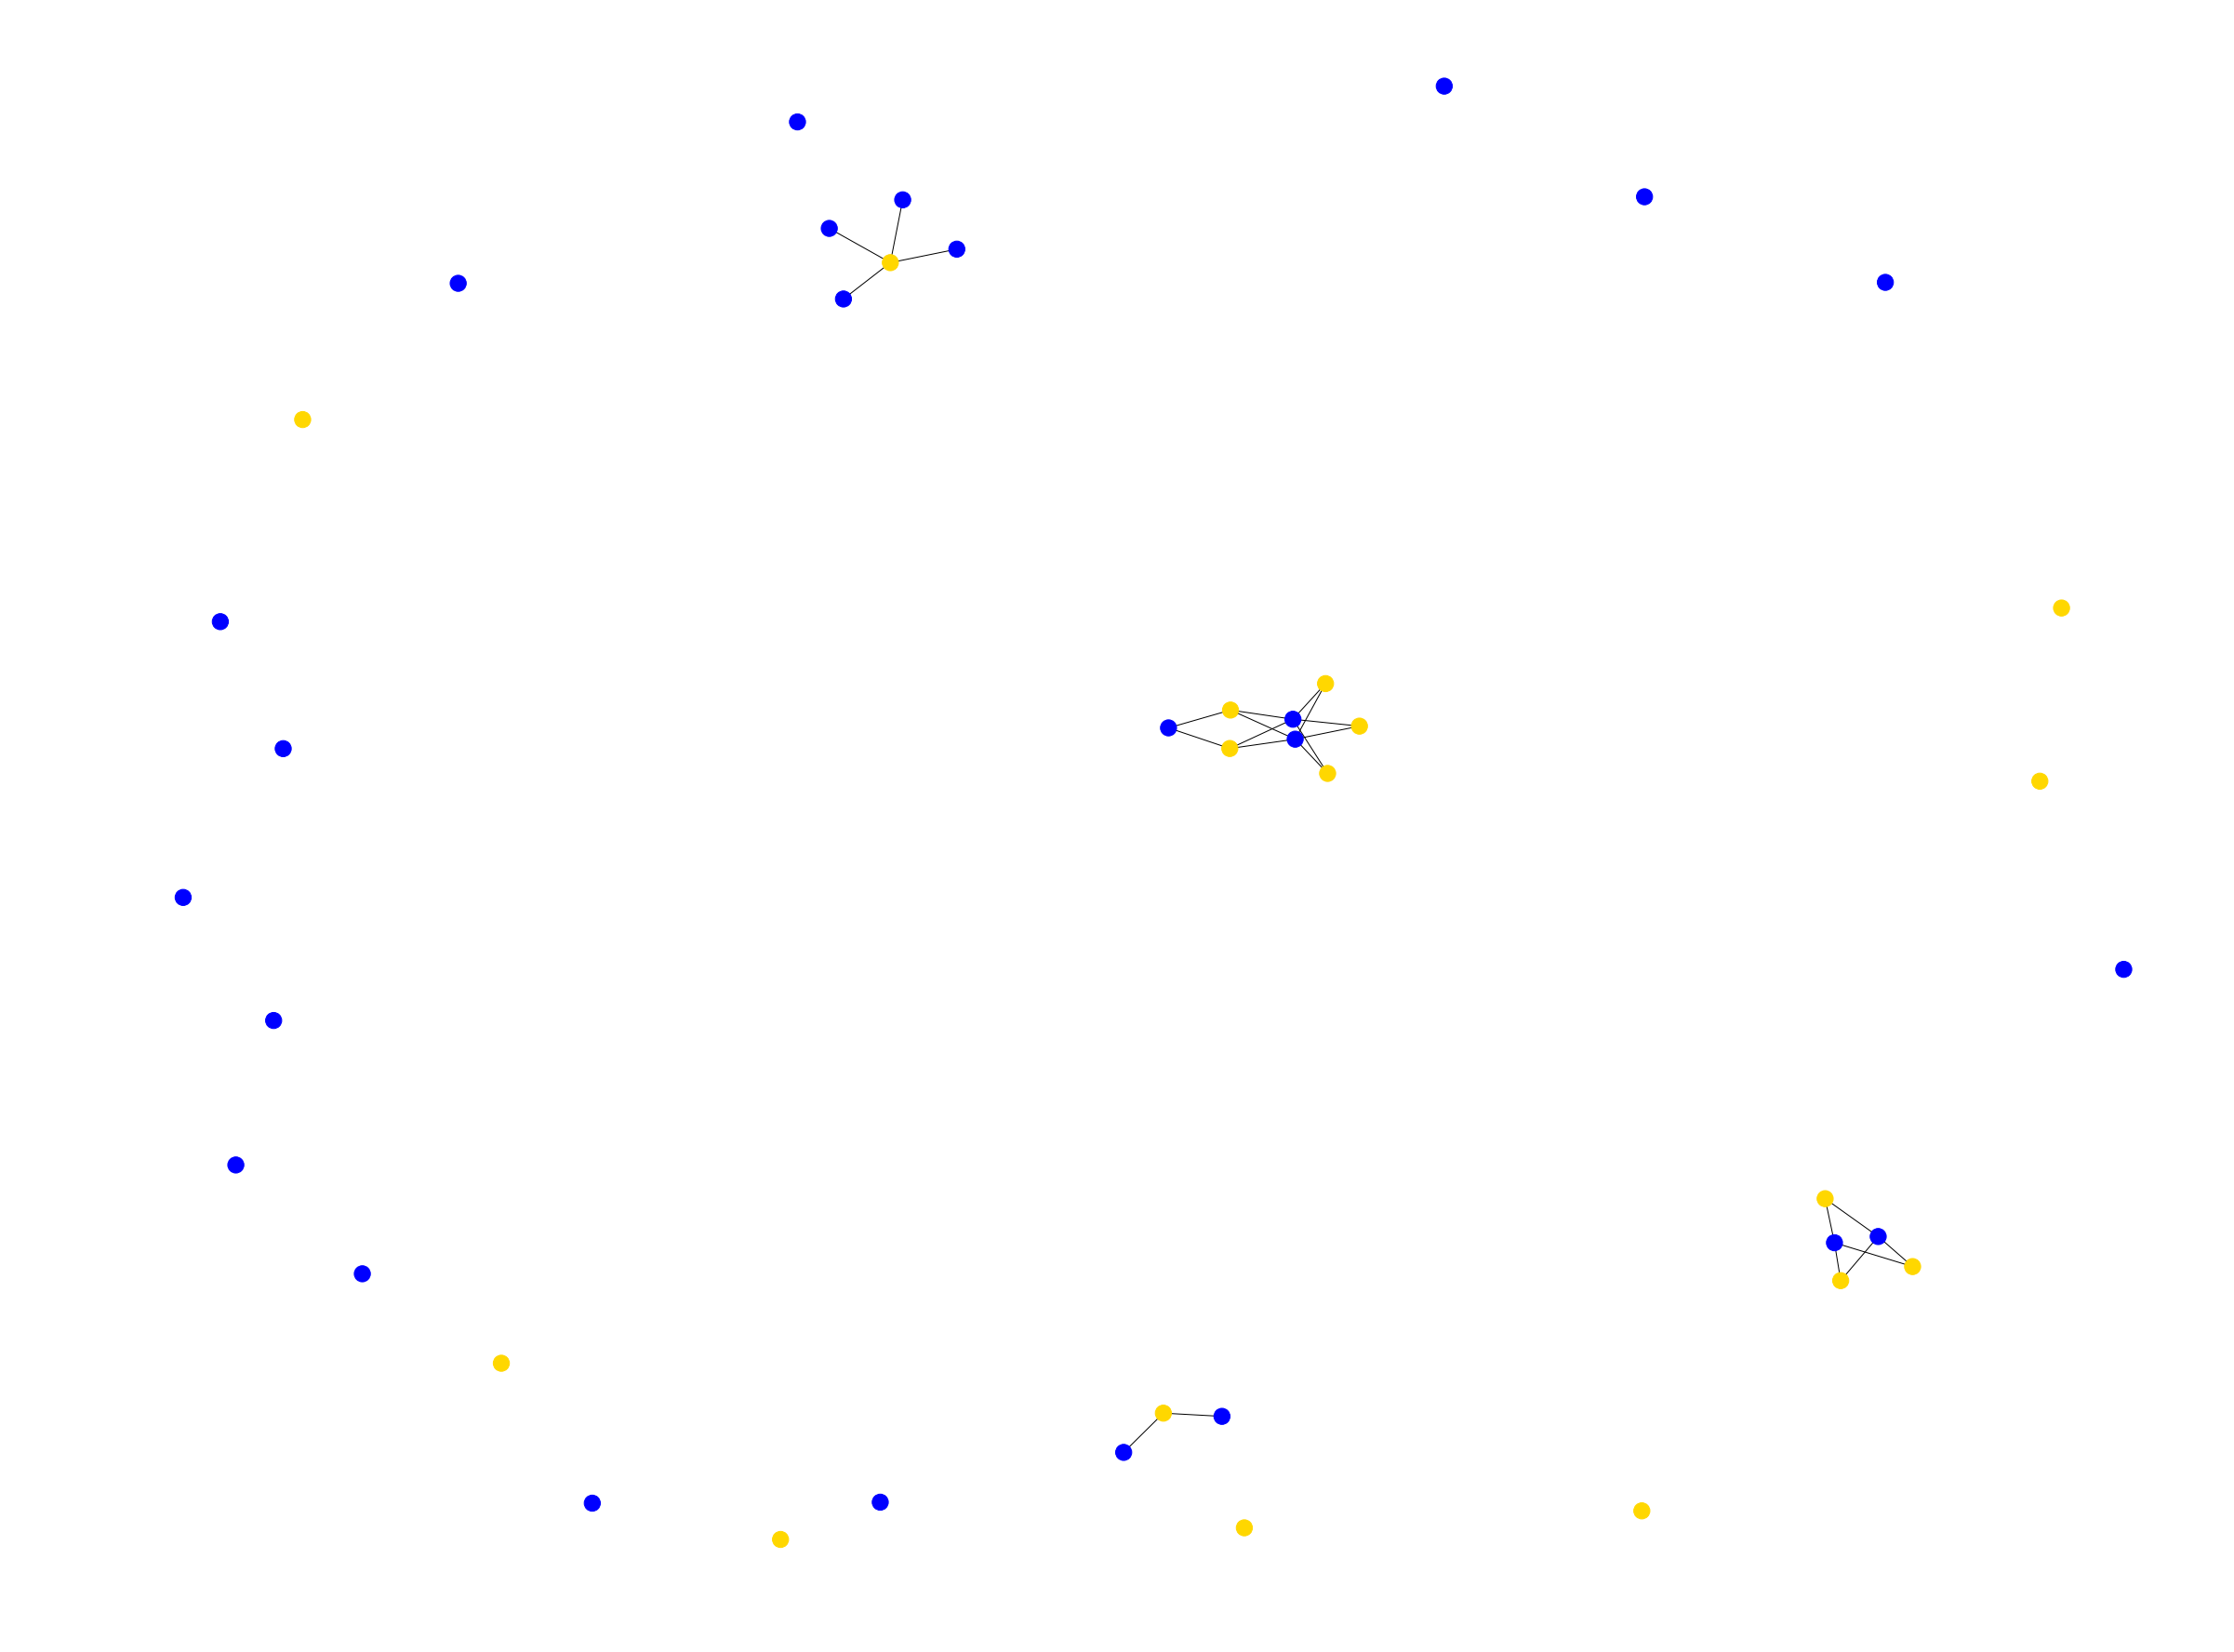

In [125]:
Goi, colorMap = graphTwoSetsByObservations(hotels,interests)
nx.draw(Goi, node_color=colorMap)

In [166]:
len(getIsolatesAtOffset(Goi,len(hotels)-1))

14

In [177]:
[minLat,maxLat],[minLon,maxLon] = getBoundingBox(hotels+interests)
optimals = []

horizontalMetres = seperationInMetres((minLat,minLon),(minLat,maxLon))
verticalMetres = seperationInMetres((minLat,minLon),(maxLat,minLon))

print(horizontalMetres,verticalMetres)

currentIsolates = len(getIsolatesAtOffset(Goi,len(hotels)-1))

currLatOffset = 0
currLonOffset = 0

while currLonOffset+100 < horizontalMetres:
    while abs(currLatOffset)+100 < verticalMetres:
        newLat, newLon = transformLatLonByXMetres(maxLat,minLon,currLatOffset,currLonOffset)
        newHotels = convertToUsableLatLon(addPseudoHotel(newLat,newLon))
        
        Goi, colorMap = graphTwoSetsByObservations(newHotels,interests)
        if(len(getIsolatesAtOffset(Goi,len(newHotels)-1)) < currentIsolates):
            currentIsolates = len(getIsolatesAtOffset(Goi,len(newHotels)-1))
            optimals = [newLat,newLon]
        
        currLatOffset -= 100
    
    currLonOffset += 100
    currLatOffset = 0
    
optimals

6130.895797321686 8416.97281716638


[56.882495621816346, -6.172800731120484]

In [184]:
def generateMappableNetwork(processedCoordsListOne,processedCoordsListTwo,fullProcessedCoordsList, G, filename):
    linkMatrix = list(map(lambda x: [fullProcessedCoordsList[x[0]],fullProcessedCoordsList[x[1]]],G.edges()))
    
    
    locs1 = list(map(lambda x: {"location": ",".join([str(x[0]),str(x[1])]), "size":0.03, "desc":""},processedCoordsListOne))
    locs2 = list(map(lambda x: {"location": ",".join([str(x[0]),str(x[1])]), "size":0.03, "desc":""},processedCoordsListTwo))
    locs3 = [{"location": "56.882495621816346,-6.172800731120484", "size":0.03, "desc":""}]
    building = {}
    building["result"] = [{"plots":{"locs":locs1,"linkMatrix":linkMatrix}, "configs": {"marker": './fullColMarkers/marker76.png', "lineColor": "#FF0000"}}]
    building["result"].append({"plots":{"locs":locs2}, "configs": {"marker": './fullColMarkers/marker2.png'}})
    building["result"].append({"plots":{"locs":locs3}, "configs": {"marker": './fullColMarkers/marker18.png'}})
    content = json.dumps(building)
    
    with open(filename, "a") as f:
        f.write(content)

interests = convertToUsableLatLon(pointsOfInterest())
hotels = convertToUsableLatLon(listedEiggHotels())
Goi, colorMap = graphTwoSetsByObservations(hotels,interests)

generateMappableNetwork(hotels,interests,hotels+interests,Goi,"testingNewHotel.txt")